# Import libraries and functions

In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from olist.seller import Seller
from olist.product import Product

warnings.filterwarnings('ignore')

# Declarations

In [3]:
# Declarations
def review_score_cost(review_score):
    """
    Returns the cost in BRL of a review score.
    """
    review_score_cost_dict = {
        1: 100,
        2: 50,
        3: 40
    }
    return review_score_cost_dict.get(int(review_score),0)

def it_cost(order_count):
    """
    Returns the IT cost in BRL based on number of orders.
    IT cost is expected to be proportional to square root of total orders.
    A constant is given, was computed once (BRL500_000 for original number of orders of 99_441)
    and is hardcoded below to improve run time.
    """
    return np.round(1_585.5767 * (order_count**0.5),0)

# Original IT cost in BRL
it_cost_base = 500_000

# Monthly per-seller revenue in BRL
per_seller_revenue_monthly = 80

# Commission on sale of product, expressed as percentage of price
per_product_commission = 0.1

# Dataframe magic

## Raw data

In [5]:
seller = Seller()
s_data = seller.data
product = Product()

## More detailed Sales Dataframe

In [10]:
# Create dataframe df_seller_sales_detailed
df_seller_sales_detailed = s_data["order_items"][["seller_id", "price", "order_id", "order_item_id", "shipping_limit_date"]]. \
merge(s_data["orders"][["order_id", "order_purchase_timestamp", "order_delivered_carrier_date"]], on="order_id", how="right").drop_duplicates(). \
merge(seller.order.get_review_score()[["review_score", "order_id"]], on = "order_id", how="inner").drop_duplicates()

# Add a total_products and then fraction column when an order had multiple parts, so that IT costs are accurately reflected
df_seller_sales_detailed = df_seller_sales_detailed.merge( \
                               df_seller_sales_detailed.groupby("order_id"). \
                               agg("max")[["order_item_id"]]. \
                               rename(columns={"order_item_id": "total_products"}), on="order_id", how="inner")
df_seller_sales_detailed["fraction"] = 1 / df_seller_sales_detailed["total_products"]

# Sort so the groupby works properly
df_seller_sales_detailed.sort_values(by = ["seller_id", "order_purchase_timestamp"], inplace=True)

In [30]:
df_seller_sales_detailed.head()

,seller_id,price,order_id,order_item_id,shipping_limit_date,order_purchase_timestamp,order_delivered_carrier_date,review_score,total_products,fraction,olist_commission,cost_of_review
79713,0015a82c2db000af6aaaf3ae2ecb0532,895.0,d455a8cb295653b55abda06d434ab492,1.0,2017-10-12 22:24:16,2017-09-26 22:17:05,2017-09-29 15:53:03,5,1.0,1.0,89.50,0.0
555,0015a82c2db000af6aaaf3ae2ecb0532,895.0,9dc8d1a6f16f1b89874c29c9d8d30447,1.0,2017-10-18 14:49:22,2017-10-12 13:33:22,2017-10-17 15:42:42,5,1.0,1.0,89.50,0.0
87252,0015a82c2db000af6aaaf3ae2ecb0532,895.0,7f39ba4c9052be115350065d07583cac,1.0,2017-10-24 23:56:20,2017-10-18 08:16:34,2017-10-20 14:29:01,1,1.0,1.0,89.50,100.0
5522,001cca7ae9ae17fb1caed9dfb1094831,99.9,3c655487f0c8e34cde2c7b67de8f08cc,1.0,2017-02-08 19:06:04,2017-02-04 19:06:04,2017-02-10 09:24:35,2,1.0,1.0,9.99,50.0
104253,001cca7ae9ae17fb1caed9dfb1094831,99.9,eb188a175542057d90b3ca5628b7b5a0,1.0,2017-02-22 23:26:24,2017-02-18 23:26:24,2017-02-21 07:07:39,4,5.0,0.2,9.99,0.0


In [34]:
# Convert time columns to datetime
df_seller_sales_detailed['order_delivered_carrier_date'] = pd.to_datetime(df_seller_sales_detailed['order_delivered_carrier_date'])
df_seller_sales_detailed['shipping_limit_date'] = pd.to_datetime(df_seller_sales_detailed['shipping_limit_date'])
df_seller_sales_detailed['order_purchase_timestamp'] = pd.to_datetime(df_seller_sales_detailed['order_purchase_timestamp'])

In [35]:
# Additional columns
df_seller_sales_detailed["olist_commission"] = per_product_commission * df_seller_sales_detailed["price"]
df_seller_sales_detailed["cost_of_review"] = df_seller_sales_detailed["fraction"] * df_seller_sales_detailed["review_score"].apply(review_score_cost)
df_seller_sales_detailed["delay_to_carrier"] = np.maximum(0,(df_seller_sales_detailed["order_delivered_carrier_date"] - df_seller_sales_detailed["shipping_limit_date"])/np.timedelta64(24, 'h'))
df_seller_sales_detailed["time_to_carrier"] = np.maximum(0,(df_seller_sales_detailed["order_delivered_carrier_date"] - df_seller_sales_detailed["order_purchase_timestamp"])/np.timedelta64(24, 'h'))

In [37]:
# Add month from first sale coluumn
df_seller_sales_detailed = df_seller_sales_detailed.merge( \
                               df_seller_sales_detailed.groupby("seller_id"). \
                               agg("min")[["order_purchase_timestamp"]]. \
                               rename(columns={"order_purchase_timestamp": "first"}), on="seller_id", how="inner")
df_seller_sales_detailed["month"] = 1 + np.floor((df_seller_sales_detailed["order_purchase_timestamp"] - df_seller_sales_detailed["first"])/np.timedelta64(1, 'M'))

# Add months on platform identifier
df_seller_sales_detailed = df_seller_sales_detailed.merge( \
                               df_seller_sales_detailed.groupby("seller_id")[["month"]].max(), on="seller_id", how="inner"). \
                               rename(columns={"month_x": "month", "month_y": "months_active"})

# Clean-up
df_seller_sales_detailed = df_seller_sales_detailed[[
    "seller_id", "month", "months_active", "price", "olist_commission", "review_score", \
    "cost_of_review", "order_item_id", "delay_to_carrier", "time_to_carrier", "fraction"]]. \
    rename(columns={"order_item_id" : "volume", "price" : "raw_sales"})

## Dataframe for monthly sales

In [38]:
# Define dict for first aggregation
agg_dict={
    "raw_sales" : "sum",
    "olist_commission" : "sum",
    "review_score" : "sum",
    "cost_of_review" : "sum",
    "volume" : "count",
    "delay_to_carrier" : "sum",
    "time_to_carrier" : "sum",
    "fraction" : "sum",
    "months_active" : "max"
}

# Create first aggregation and remove NAs
df_seller_monthly = df_seller_sales_detailed.groupby(["seller_id","month"]).agg(agg_dict)
df_seller_monthly.fillna(0, inplace=True)

# Add monthly fee
df_seller_monthly["olist_seller_fee"] = per_seller_revenue_monthly

# Add IT costs columns. Calculated as share of total
df_seller_monthly["it_cost"] = it_cost_base * df_seller_monthly["fraction"] / df_seller_monthly["fraction"].sum()

# Create cumulative data points
df_seller_monthly[
    ["raw_sales_cum", "olist_commission_cum", "cost_of_review_cum", "volume_cum", "fraction_cum", "it_cost_cum", "olist_seller_fee_cum", "review_score_cum", "delay_to_carrier_cum", "time_to_carrier_cum"
    ]] = df_seller_monthly.groupby("seller_id")[[
    "raw_sales", "olist_commission", "cost_of_review", "volume", "fraction", "it_cost", "olist_seller_fee", "review_score", "delay_to_carrier", "time_to_carrier"
]].cumsum()

# Tidy up the ones that are actually means, not sums
df_seller_monthly["review_score"] = df_seller_monthly["review_score"] / df_seller_monthly["volume"]
df_seller_monthly["review_score_cum"] = df_seller_monthly["review_score_cum"] / df_seller_monthly["volume_cum"]
df_seller_monthly["delay_to_carrier"] = df_seller_monthly["delay_to_carrier"] / df_seller_monthly["volume"]
df_seller_monthly["delay_to_carrier_cum"] = df_seller_monthly["delay_to_carrier_cum"] / df_seller_monthly["volume_cum"]
df_seller_monthly["time_to_carrier"] = df_seller_monthly["time_to_carrier"] / df_seller_monthly["volume"]
df_seller_monthly["time_to_carrier_cum"] = df_seller_monthly["time_to_carrier_cum"] / df_seller_monthly["volume_cum"]

# Add seller_pl
df_seller_monthly["seller_pl"] = df_seller_monthly["olist_commission"] + df_seller_monthly["olist_seller_fee"] - df_seller_monthly["cost_of_review"] - df_seller_monthly["it_cost"]
df_seller_monthly["seller_pl_cum"] = df_seller_monthly["olist_commission_cum"] + df_seller_monthly["olist_seller_fee_cum"] - df_seller_monthly["cost_of_review_cum"] - df_seller_monthly["it_cost_cum"]
df_seller_monthly["seller_pl_avg"] = df_seller_monthly["seller_pl_cum"] / df_seller_monthly.index.get_level_values(1)

# Clean-up
df_seller_monthly = df_seller_monthly.reset_index().merge(seller.get_seller_features(), on="seller_id", how="inner")[[
    "seller_id",
    "month",
    "months_active",
    "seller_city",
    "seller_state",
    "raw_sales",
    "raw_sales_cum",
    "olist_commission",
    "olist_commission_cum",
    "review_score",
    "review_score_cum",
    "cost_of_review",
    "cost_of_review_cum",
    "it_cost",
    "it_cost_cum",
    "volume",
    "volume_cum",
    "fraction",
    "fraction_cum",
    "delay_to_carrier",
    "delay_to_carrier_cum",
    "time_to_carrier",
    "time_to_carrier_cum",
    "olist_seller_fee",
    "olist_seller_fee_cum",
    "seller_pl",
    "seller_pl_cum",
    "seller_pl_avg"
]]

## Seller-product category map

In [39]:
# Map seller and product_categories
df_seller_product_map = s_data["order_items"][["seller_id", "product_id"]].drop_duplicates(). \
merge(s_data["products"][["product_id", "product_category_name"]], on="product_id", how="inner")[["seller_id", "product_category_name"]].drop_duplicates(). \
merge(s_data["product_category_name_translation"][["product_category_name", "product_category_name_english"]], on="product_category_name", how="inner")[["seller_id", "product_category_name_english"]]

# Add count for each category
df_seller_product_map = df_seller_product_map.merge(df_seller_product_map.groupby("product_category_name_english").count(), on="product_category_name_english")

#Clean-up
df_seller_product_map.rename(columns={"seller_id_x" : "seller_id", "product_category_name_english" : "product_category", "seller_id_y" : "seller_count"}, inplace=True)
df_seller_product_map.sort_values("seller_count", ascending=False, inplace=True)

## Product category map

In [40]:
# Map seller and product_categories
df_product_category_map = s_data["products"]. \
merge(s_data["product_category_name_translation"][["product_category_name", "product_category_name_english"]], on="product_category_name", how="inner")[["product_id", "product_category_name_english"]]

#Clean-up
df_product_category_map.rename(columns={"product_category_name_english" : "product_category"}, inplace=True)

## Detailed Sales per Product

In [41]:
# Create dataframe df_product_sales_detailed
df_product_sales_detailed = s_data["order_items"][["product_id", "price", "order_id", "order_item_id", "shipping_limit_date"]]. \
merge(s_data["orders"][["order_id", "order_purchase_timestamp", "order_delivered_carrier_date"]], on="order_id", how="right").drop_duplicates(). \
merge(s_data["order_reviews"][["review_score", "order_id"]], on = "order_id", how="left").drop_duplicates(["product_id", "order_id", "order_item_id"])

# Add a total_products and then fraction column when an order had multiple parts, so that IT costs are accurately reflected
df_product_sales_detailed = df_product_sales_detailed.merge( \
                               df_product_sales_detailed.groupby("order_id"). \
                               agg("max")[["order_item_id"]]. \
                               rename(columns={"order_item_id": "total_products"}), on="order_id", how="inner")
df_product_sales_detailed["fraction"] = 1 / df_product_sales_detailed["total_products"]

# Additional columns
df_product_sales_detailed["olist_commission"] = per_product_commission * df_product_sales_detailed["price"]
df_product_sales_detailed["cost_of_review"] = df_product_sales_detailed["fraction"] * df_product_sales_detailed["review_score"].apply(review_score_cost)

# Clean-up
df_product_sales_detailed = df_product_sales_detailed[[
    "product_id", "price", "olist_commission", "review_score", \
    "cost_of_review", "order_item_id", "fraction"]]. \
    rename(columns={"order_item_id" : "volume", "price" : "raw_sales"})

## Product Sales

In [42]:
# Define dict for first aggregation
agg_dict={
    "raw_sales" : "sum",
    "olist_commission" : "sum",
    "review_score" : "sum",
    "cost_of_review" : "sum",
    "volume" : "count",
    "fraction" : "sum"
}

# Create first aggregation and remove NAs
df_product = df_product_sales_detailed.groupby(["product_id"]).agg(agg_dict)
df_product.fillna(0, inplace=True)

# Add IT costs columns. Calculated as share of total
df_product["it_cost"] = it_cost_base * df_product["fraction"] / df_product["fraction"].sum()

# Tidy up the ones that are actually means, not sums
df_product["rs"] = df_product["review_score"]
df_product["review_score"] = df_product["review_score"] / df_product["volume"]


# Add product_pl
df_product["product_pl"] = df_product["olist_commission"] - df_product["cost_of_review"] - df_product["it_cost"]

# Clean-up
df_product = df_product.reset_index()[[
    "product_id",
    "raw_sales",
    "olist_commission",
    "review_score",
    "cost_of_review",
    "it_cost",
    "volume",
    "fraction",
    "product_pl",
    "rs"
]].sort_values(["product_pl"])

## Product category sales

In [43]:
# Define dict for aggregation
agg_dict={
    "raw_sales" : "sum",
    "olist_commission" : "sum",
    "rs" : "sum",
    "cost_of_review" : "sum",
    "volume" : "sum",
    "it_cost" : "sum",
    "fraction" : "sum",
    "category_pl" : "sum"
}

# Create dataframe
df_product_category = df_product.merge(s_data["products"][["product_id", "product_category_name"]], on="product_id", how="left"). \
merge(s_data["product_category_name_translation"][["product_category_name", "product_category_name_english"]], on="product_category_name", how="left"). \
rename(columns={"product_pl" : "category_pl", "product_category_name_english" : "product_category"})

# Create "Other" category for items that do not have one
df_product_category.fillna("unidentified", inplace=True)

# Group by category
df_product_category = df_product_category.groupby("product_category").agg(agg_dict)

# Tidy up columns
df_product_category["review_score"] = df_product_category["rs"] / df_product_category["volume"]

# Average item price
df_product_category["average_price"] = df_product_category["raw_sales"] / df_product_category["volume"]

# Clean-up
df_product_category = df_product_category.reset_index()[[
    "product_category",
    "raw_sales",
    "average_price",
    "olist_commission",
    "review_score",
    "cost_of_review",
    "it_cost",
    "volume",
    "fraction",
    "category_pl"
]].sort_values(["category_pl"])

# Exploratory Analysis

## Looking at it costs vs nr of orders

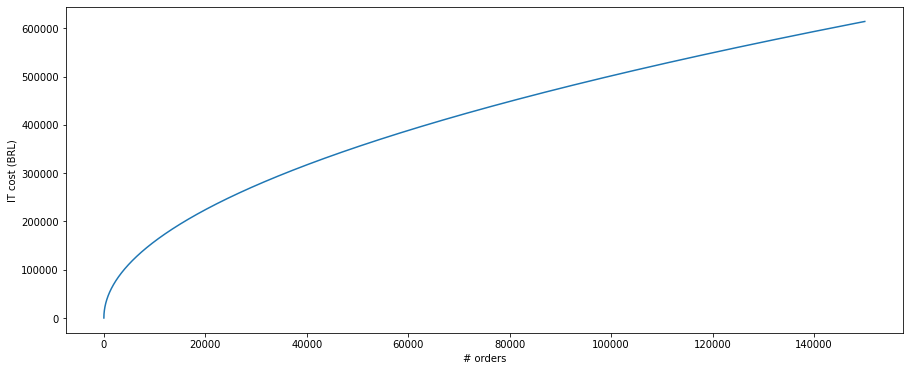

In [44]:
it_x = np.arange(0,150_000,1)
plt.figure(figsize=(15,6))
sns.lineplot(x=it_x, y=1_585.5767 * (it_x**0.5))
plt.xlabel("# orders")
plt.ylabel("IT cost (BRL)");

Conclusions:

    Since this is a root function, marginal costs diminish with growing order number.

=> The marginal cost of removing an additional seller may grow. Conversely, further growth will reduce the impact of IT cost on overall P/L.

## cumulative review scores vs. months on platform

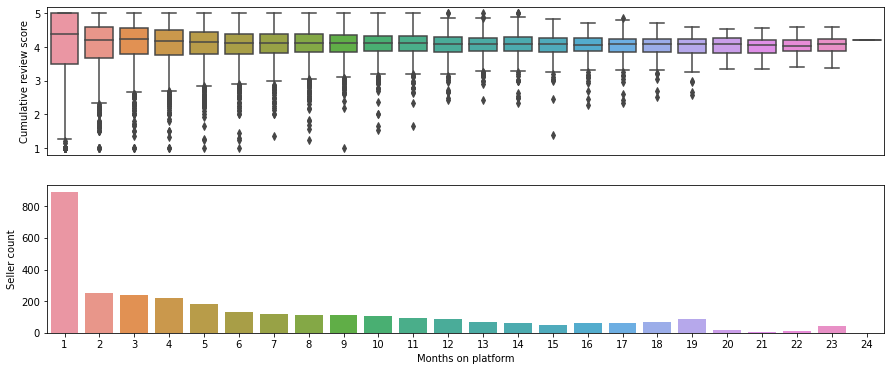

In [45]:
temp = df_seller_monthly.groupby("months_active").seller_id.nunique().to_frame().reset_index()

plt.figure(figsize=(15,6))
ax1 = plt.subplot(2,1,1)
sns.boxplot(data=df_seller_monthly, x="month", y="review_score_cum")
ax1.set_ylabel("Cumulative review score")
ax1.set_xlabel("")
ax1.get_xaxis().set_ticks([])
ax2 = plt.subplot(2,1,2)
sns.barplot(y=temp["seller_id"], x=temp["months_active"].astype(int))
ax2.set_ylabel("Seller count")
ax2.set_xlabel("Months on platform");

Conclusions:

    The average seller has a long-run review score between 3.5 and 4.5.
    Most sellers have not been on the platform very long.

=> A few long-time sellers might be causing most of the losses.

## Plotting average seller P/L

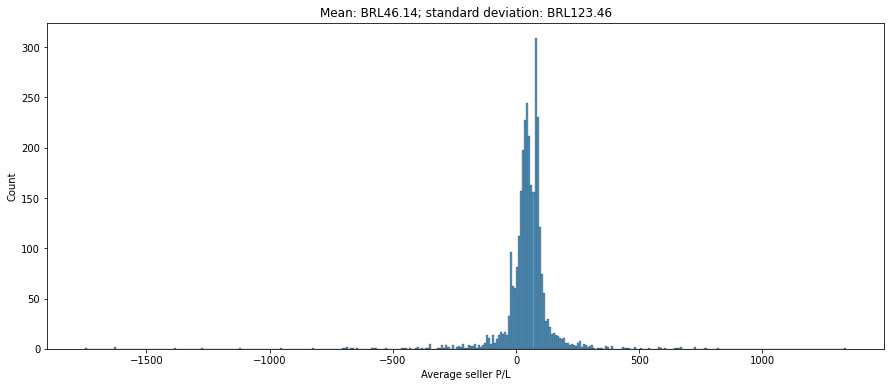

In [46]:
plot_x = df_seller_monthly.sort_values(["seller_id", "month"]).groupby("seller_id").last()["seller_pl_avg"]

plt.figure(figsize=(15,6))
sns.histplot(x=plot_x)
plt.title(f"Mean: BRL{np.round(plot_x.mean(),2)}; standard deviation: BRL{np.round(plot_x.std(),2)}")
plt.xlabel("Average seller P/L")
plt.ylabel("Count");

Conclusions:

    Olist just about breaks even on the average seller at current levels.

=> This is not unexpected as the company is still in growth mode and is not yet fully benefiting from economies of scale.

## Does the average seller P/L improve over time?

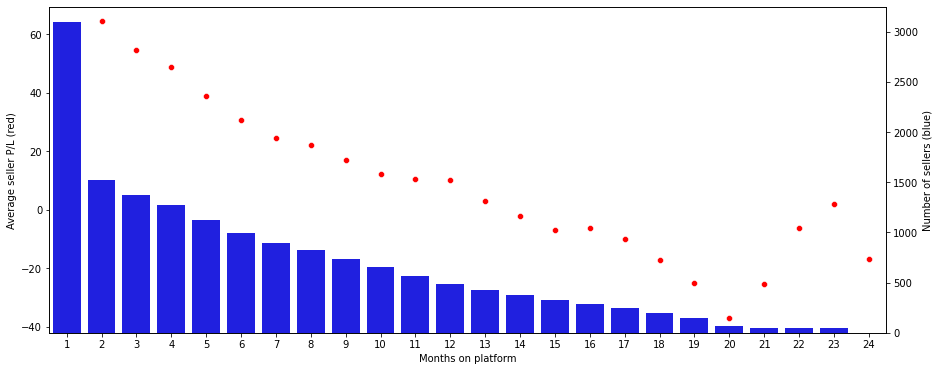

In [47]:
def seller_pl_plot(df, title_string=False):
    average_PL = df.groupby("month").mean()["seller_pl_avg"]
    count_sellers = df.groupby("month").count()["seller_id"]
    months = average_PL.index.values.astype(int)

    plt.figure(figsize=(15,6))
    sns.scatterplot(x=months, y=average_PL, color="red")
    plt.ylabel("Average seller P/L (red)")
    plt.xlabel("Months on platform")
    ax2 = plt.twinx()
    sns.barplot(x=months, y=count_sellers, ax=ax2, color="blue")
    ax2.set_ylabel("Number of sellers (blue)");
    if title_string:
        plt.title(f"After removing {title_string} worst sellers")
    
seller_pl_plot(df_seller_monthly)

Conclusions:

    Seller P/L appears to drop off month after month.

=> Since there are only few sellers who have a long runtime, perhaps this is due to a few bad apples?

## No of sellers per product category

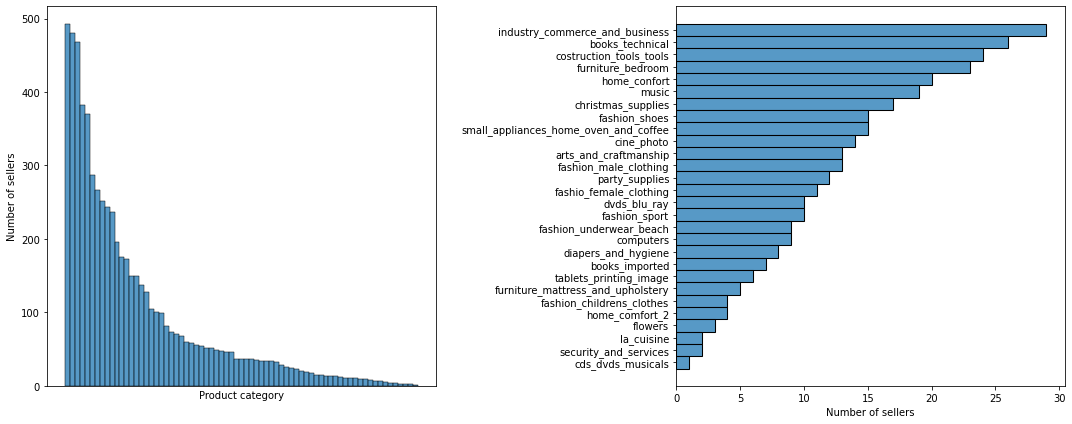

In [48]:
plt.figure(figsize=(15,6))
ax1 = plt.subplot(1,2,1)
sns.histplot(x="product_category", data=df_seller_product_map)
ax1.set_ylabel("Number of sellers")
ax1.set_xlabel("Product category")
ax1.get_xaxis().set_ticks([])
ax2 = plt.subplot(1,2,2)
sns.histplot(y=df_seller_product_map[df_seller_product_map["seller_count"]<30]["product_category"])
plt.tight_layout()
ax2.set_xlabel("Number of sellers")
ax2.set_ylabel("");

Conclusions:

    Quite a few categories have few sellers.

=> We may end up eliminating entire categories by removing sellers.

## Product P/L

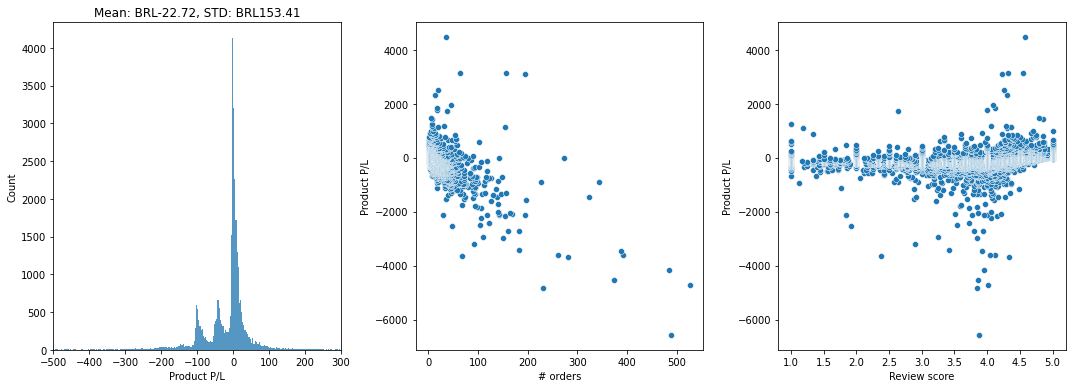

In [49]:
# Distribution of P/L
plot_x_p = df_product["product_pl"]
plt.figure(figsize=(15,5.5))
plt.subplot(1,3,1)
sns.histplot(x=plot_x_p)
plt.xlim(left=-500, right=300)
plt.title(f"Mean: BRL{np.round(plot_x_p.mean(),2)}, STD: BRL{np.round(plot_x_p.std(),2)}")
plt.xlabel("Product P/L")
ax2 = plt.subplot(1,3,2)
sns.scatterplot(x="volume", y="product_pl", data=df_product)
ax2.set_xlabel("# orders")
ax2.set_ylabel("Product P/L")
ax3 = plt.subplot(1,3,3)
sns.scatterplot(x="review_score", y="product_pl", data=df_product)
ax3.set_xlabel("Review score")
ax3.set_ylabel("Product P/L")
plt.tight_layout();

Conclusions:

    The average product loses money, a few quite significantly.
    High-volume products appear to cause higher losses - possibly because they are low-value.
    Review score has a neglible influence on P/L, other than saving cost at >3.

=> This must be offset by the monthly seller fee. It is in Olist's interest to have many sellers with low activity on the platform.

## Product category P/L

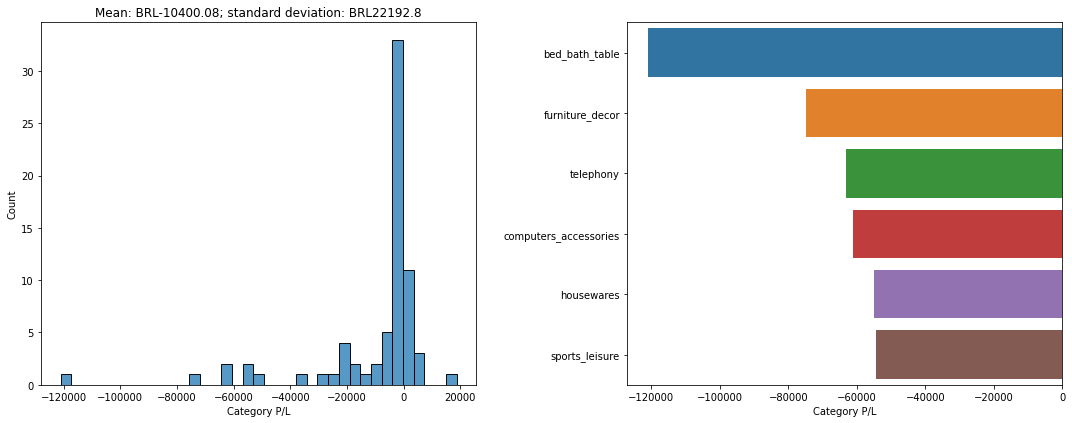

In [50]:
# Distribution of P/L
plot_x_c = df_product_category["category_pl"]
plt.figure(figsize=(15,6))
ax1 = plt.subplot(1,2,1)
sns.histplot(x=plot_x_c)
ax1.set_xlabel("Category P/L")
ax1.set_ylabel("Count")
ax1.set_title(f"Mean: BRL{np.round(plot_x_c.mean(),2)}; standard deviation: BRL{np.round(plot_x_c.std(),2)}")
ax2 = plt.subplot(1,2,2)
sns.barplot(y=df_product_category[df_product_category["category_pl"]<-50000]["product_category"], x=df_product_category[df_product_category["category_pl"]<-50000]["category_pl"])
plt.tight_layout()
ax2.set_xlabel("Category P/L")
ax2.set_ylabel("");

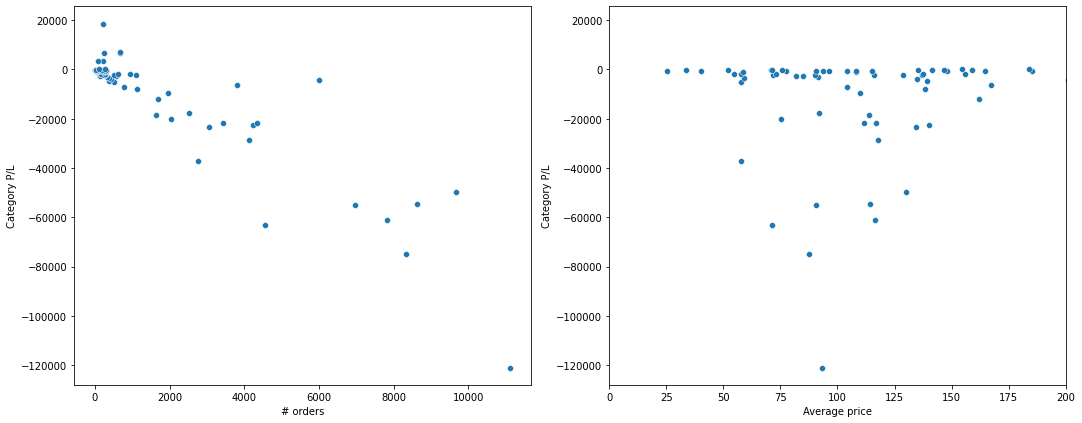

In [51]:
# Product category P/L vs. volume
plt.figure(figsize=(15,6))
ax1 = plt.subplot(1,2,1)
sns.scatterplot(x="volume", y="category_pl", data=df_product_category)
ax1.set_ylabel("Category P/L")
ax1.set_xlabel("# orders")
ax2 = plt.subplot(1,2,2)
sns.scatterplot(x="average_price", y="category_pl", data=df_product_category)
plt.tight_layout()
ax2.set_xlim(left=0, right=200)
ax2.set_xlabel("Average price")
ax2.set_ylabel("Category P/L");

Conclusions:

    There is no clear correlation between average product price in a category and its P/L
    Some product categories consistently show negative P/L

=> Some product categories may have to be removed.

# Further Investigation

Approach and assumptions

- What matters to Olist is positive seller P/L as this will drive profit.
- The ideal seller on Olist has very few, infrequent and high-price sales with a review score of 2+.
- The proportion of IT costs attributable to each order increases as overall order volume decreases.
- Olist is looking to maximize overall profit.
- A bad seller is characterized by negative P/L.
- Removing bad sellers, or loss-making products, will increase profit but may make platform less attractive.

Effect of removing worst seller - simplistic approach

Worst seller defines seller with worst average monthly seller P/L seller_pl_avg


## Reduce dataframe gradually by removing worst seller¶

In [52]:
def remove_sellers(remove_seller_count=1000):
    # Set up tracker variables
    new_mean = []
    new_std = []
    new_total = []

    # Create temporary copy of df
    df_seller_monthly_temp = df_seller_monthly.copy()

    # Remove and record
    df_seller_monthly_temp = df_seller_monthly.copy().set_index("seller_id")
    for i in range(remove_seller_count):
        
        # Find ID of worst seller, sorted by cumulative seller P/L, only keeping last relevant month per seller
        seller_id = df_seller_monthly_temp.sort_values(["seller_id", "month"]).groupby("seller_id").last().sort_values("seller_pl_avg").iloc[i].name

        # Drop seller from df
        df_seller_monthly_temp.drop([seller_id], inplace=True)

        # Recalculate IT cost and seller P/L
        order_number = df_seller_monthly_temp.fraction.sum()
        it_cost_base_current = it_cost(order_number)
        df_seller_monthly_temp["it_cost"] = it_cost_base_current * df_seller_monthly_temp["fraction"] / df_seller_monthly_temp["fraction"].sum()
        df_seller_monthly_temp["it_cost_cum"] = df_seller_monthly_temp.groupby("seller_id")["it_cost"].cumsum()
        df_seller_monthly_temp["seller_pl"] = df_seller_monthly_temp["olist_commission"] + df_seller_monthly_temp["olist_seller_fee"] - df_seller_monthly_temp["cost_of_review"] - df_seller_monthly_temp["it_cost"]
        df_seller_monthly_temp["seller_pl_cum"] = df_seller_monthly_temp["olist_commission_cum"] + df_seller_monthly_temp["olist_seller_fee_cum"] - df_seller_monthly_temp["cost_of_review_cum"] - df_seller_monthly_temp["it_cost_cum"]
        df_seller_monthly_temp["seller_pl_avg"] = df_seller_monthly_temp["seller_pl_cum"] / df_seller_monthly_temp["month"]

        # Obtain list of average seller P/Ls
        seller_pl_list = df_seller_monthly_temp.sort_values(["seller_id", "month"]).groupby("seller_id").last()["seller_pl_avg"]
        seller_pl_mean = np.round(seller_pl_list.mean(),2)
        seller_pl_std = np.round(seller_pl_list.std(),2)

        # Append to the tracker variables
        new_mean.append(seller_pl_mean)
        new_std.append(seller_pl_std)
        new_total.append(seller_pl_list.sum())
        
    return new_mean, new_std, new_total, df_seller_monthly_temp.reset_index()

new_mean, new_std, new_total, df_seller_monthly_temp = remove_sellers()

## When does seller P/L peak? How many bad apples do we have to remove?

In [53]:
# Find max value
sellers_removed_total = new_total.index(max(new_total))+1
sellers_removed_mean = new_mean.index(max(new_mean))+1

## Plot total seller P/L and average seller P/L¶

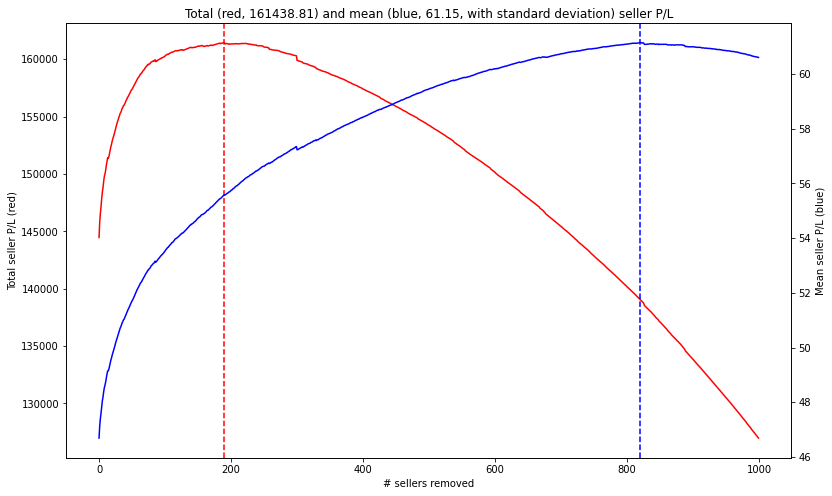

In [54]:
# Straight x values
removed_x = np.arange(0,len(new_mean),1)

# Plot
plt.figure(figsize=(13,8))

# Totals
plot_title = f"Total (red, {np.round(new_total[sellers_removed_total-1],2)}) and mean (blue, {np.round(new_mean[sellers_removed_mean-1],2)}, with standard deviation) seller P/L"
plt.title(plot_title)

sns.lineplot(x=removed_x, y=new_total, color="red")
plt.axvline(x=sellers_removed_total, ymin=0, ymax=new_total[sellers_removed_total-1], color="red", linestyle="dashed")
plt.xlabel("# sellers removed")
plt.ylabel("Total seller P/L (red)")
ax2 = plt.twinx()
sns.lineplot(x=removed_x, y=new_mean, ax=ax2, color="blue")
ax2.axvline(x=sellers_removed_mean, ymin=0, ymax=new_mean[sellers_removed_mean-1], color="blue", linestyle="dashed")
ax2.set_ylabel("Mean seller P/L (blue)");

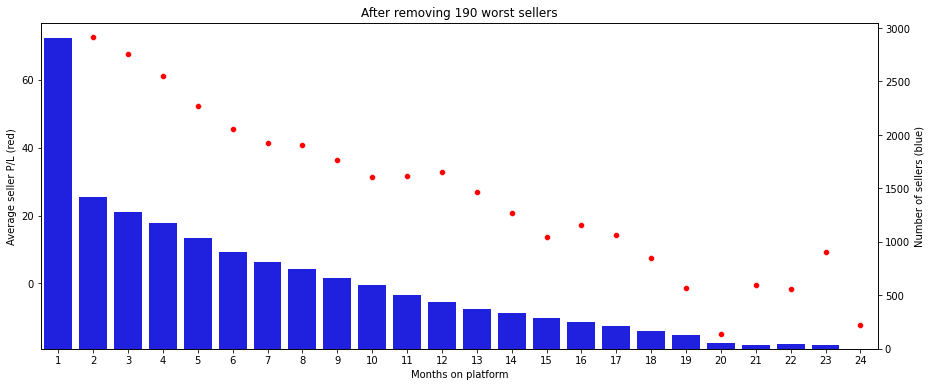

In [55]:
# Seed new dataframe with the exact number of sellers removed
new_mean, new_std, new_total, df_seller_monthly_cleaned = remove_sellers(sellers_removed_total)

# Plot
seller_pl_plot(df_seller_monthly_cleaned, sellers_removed_total)

In [56]:
# How many products and product categories have we removed?
sellers_to_remove = df_seller_monthly.sort_values(["seller_id", "month"]).groupby("seller_id").last().sort_values("seller_pl_avg").index.values[:sellers_removed_total]
category_loss = df_seller_product_map.product_category.nunique() - df_seller_product_map[~df_seller_product_map['seller_id'].isin(sellers_to_remove)].product_category.nunique()
product_loss = s_data["order_items"].product_id.nunique() - s_data["order_items"][~s_data["order_items"]["seller_id"].isin(sellers_to_remove)].product_id.nunique()

print(f"Removing {sellers_removed_total} sellers also removed {product_loss} products and {category_loss} entire category.")
print("This may affect the platform's overall attractiveness.")

Removing 190 sellers also removed 8954 products and 1 entire category.
This may affect the platform's overall attractiveness.


## Effect of removing worst product category

In [57]:
# Identify worst category
worst_category = df_product_category.iloc[0]["product_category"]

# Find all products linked to that category
worst_products = df_product_category_map[df_product_category_map["product_category"] == worst_category]["product_id"].to_list()

# Seed new dataframe with worst category removed
df_category_dropped = df_product[~df_product["product_id"].isin(worst_products)]

# Recalculate IT cost and product P/L
order_number =  df_category_dropped.fraction.sum()
it_cost_base_current = it_cost(order_number)
df_category_dropped["it_cost"] = it_cost_base_current * df_category_dropped["fraction"] / df_category_dropped["fraction"].sum()
df_category_dropped["product_pl"] = df_category_dropped["olist_commission"] - df_category_dropped["cost_of_review"] - df_category_dropped["it_cost"]

# Delta between original and new product P/L 
print(f"Removing worst category improved overall product P/L by BRL{np.round(df_category_dropped.product_pl.sum() - df_product.product_pl.sum(),2)}")

# But did this also remove any sellers?
print(f"But we also removed {df_seller_product_map.seller_id.nunique() - df_seller_product_map[df_seller_product_map['product_category'] != worst_category].seller_id.nunique()} sellers, adversely impacting monthly fee revenue.")

Removing worst category improved overall product P/L by BRL99822.01
But we also removed 77 sellers, adversely impacting monthly fee revenue.


# Fin